In [67]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pickle
import os
from pycbc.types import timeseries
from calcwf import gen_wf, chirp2total, total2chirp, match_h1_h2, get_h, match_s_f_max, match_true_anomaly

In [68]:
sample_rate = 4096

In [69]:
def const_eff_chirp(given_e, given_chirp, e_vals):
    """
    Converts array of eccentricity values to chirp mass along a line of constant 
    effective chirp mass, as given by equation 1.1 in Fawata et al. 
    https://arxiv.org/pdf/2108.05861.pdf.

    Parameters:
        given_e: Value of eccentricity for given point on line of constant effective chirp mass.
        given_chirp: Value of chirp mass for given point on line of constant effective chirp mass.
        e_vals: Frequency values to be converted.

    Returns:
        Converted chirp mass values.
    """

    # Find effective chirp mass of given point
    eff_chirp = given_chirp/(1-157*given_e**2/24)**(3/5)

    # Convert to chirp mass values
    chirp_vals = eff_chirp*(1-157*e_vals**2/24)**(3/5)

    return chirp_vals

# e^2 against chirp mass plot functions

In [70]:
# Calculates matches to a fiducial h1, h2 waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match(e_vals, chirp_vals, fiducials, f_low, approximant='TEOBResumS', max_method=None):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'h1':[], 'h1_phase':[], 'h2':[], 'h2_phase':[], 'diff_phase':[], 'quad':[]}
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Generate fiducial waveform
    _, h1, h2, _, _ = get_h([1,1], f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant=approximant)

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        matches['h1'].append([])
        matches['h1_phase'].append([])
        matches['h2'].append([])
        matches['h2_phase'].append([])
        matches['diff_phase'].append([])
        matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:

            # Calculate h1, h2 matches
            if max_method == None:
                s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)
                match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)
            else:
                match_h1, match_h2 = match_s_f_max(h1, h2, f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant, max_method=max_method)

            # Save matches
            matches['h1'][-1].append(abs(match_h1))
            matches['h1_phase'][-1].append(np.angle(match_h1))
            matches['h2'][-1].append(abs(match_h2))
            matches['h2_phase'][-1].append(np.angle(match_h2))
            matches['diff_phase'][-1].append(np.angle(match_h1) - np.angle(match_h2))
            match_quad = np.sqrt(abs(match_h1)**2+abs(match_h2**2))
            matches['quad'][-1].append(match_quad)

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [71]:
# Plots match contours on eccentricity/chirp mass plot
def ecc_chirp_plot(e_vals, chirp_vals, fiducials, matches, vmins=[0.7,0.7,0.7,0.7], vmaxs=[1,1,1,1]):
    
    # Convert to eccentricity squared
    e2_vals = e_vals**2

    # Make contour plot for  each match
    for i, key in enumerate(['h1', 'h2', 'quad']):

        # Which direction colorbar extends
        if [vmins[i], vmaxs[i]] == [0,1]:
            extend = 'neither'
        elif vmins[i] == 0:
            extend = 'max'
        elif vmaxs[i] == 1:
            extend = 'min'
        else:
            extend = 'both'

        # Plotting amplitude contours
        plt.contourf(chirp_vals, e2_vals, matches[key], np.linspace(vmins[i], vmaxs[i], 15), vmin=vmins[i], vmax=vmaxs[i], extend=extend)
        plt.colorbar(label='match')
        if key == 'h2':
            plt.contour(chirp_vals, e2_vals, matches['h1'], [0.97], colors=['C1'])
        else:
            plt.contour(chirp_vals, e2_vals, matches[key], [0.97], colors=['C1'])
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        #plt.plot(const_eff_chirp(fiducials[0], fiducials[1], e2_vals**0.5), e2_vals, c='k', ls='dashed', alpha=0.7)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

    # Plot h2/h1 ratio contours
    if vmins[3] == 0:
        extend = 'max'
    else:
        extend = 'both'
    plt.contourf(chirp_vals, e2_vals, np.array(matches['h2'])/np.array(matches['h1']), np.linspace(vmins[3], vmaxs[3], 15), vmin=vmins[3], vmax=vmaxs[3], extend=extend)
    plt.colorbar(label='match ratio')
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'h2/h1, q={fiducials[2]}')
    plt.show()

    # Make contour plot for phase of each match
    for i, key in enumerate(['h1_phase', 'h2_phase', 'diff_phase']):

        # phase
        plt.contourf(chirp_vals, e2_vals, matches[key], cmap='twilight_shifted')
        plt.colorbar(label='phase of complex overlap')
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key}, q={fiducials[2]}')
        plt.show()

        # cos(phase)
        plt.contourf(chirp_vals, e2_vals, np.cos(matches[key]))
        plt.colorbar(label='cos(phase) of complex overlap')
        plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
        plt.xlabel('$\mathcal{M}~/~M_\odot$')
        plt.ylabel('$e^2$')
        plt.title(f'{key} (cos), q={fiducials[2]}')
        plt.show()

In [72]:
# Calculates matches to a fiducial waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match_ta(e_vals, chirp_vals, fiducials, f_low, approximant='TEOBResumS', final_match='quad'):

    # Setup match dict and calculate conversion from chirp to total mass
    if final_match == 'TEOB':
        matches = {'match_amp':[], 'match_phase':[]}
    elif final_match == 'quad':
        matches = {'h1':[], 'h2':[], 'h1_phase':[], 'h2_phase':[], 'diff_phase':[], 'quad':[]}
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        if final_match == 'TEOB':
            matches['match_amp'].append([])
            matches['match_phase'].append([])
        elif final_match == 'quad':
            matches['h1'].append([])
            matches['h1_phase'].append([])
            matches['h2'].append([])
            matches['h2_phase'].append([])
            matches['diff_phase'].append([])
            matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:

            # Calculate h1, h2 matches
            s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)
            match_cplx = match_true_anomaly(s, f_low, fiducials[0], q_factor*fiducials[1], fiducials[2], sample_rate, approximant, final_match)

            # Save matches
            if final_match == 'TEOB':
                matches['match_amp'][-1].append(abs(match_cplx))
                matches['match_phase'][-1].append(np.angle(match_cplx))
            elif final_match == 'quad':
                matches['h1'][-1].append(abs(match_cplx[0]))
                matches['h1_phase'][-1].append(np.angle(match_cplx[0]))
                matches['h2'][-1].append(abs(match_cplx[1]))
                matches['h2_phase'][-1].append(np.angle(match_cplx[1]))
                matches['diff_phase'][-1].append(np.angle(match_cplx[0]) - np.angle(match_cplx[1]))
                match_quad = np.sqrt(abs(match_cplx[0])**2+abs(match_cplx[1]**2))
                matches['quad'][-1].append(match_quad)

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

In [73]:
# Plots match contours on eccentricity/chirp mass plot
def ecc_chirp_plot_ta(e_vals, chirp_vals, fiducials, matches, vmin=0.7, vmax=1):
    
    # Convert to eccentricity squared
    e2_vals = e_vals**2

    # Which direction colorbar extends
    if [vmin, vmax] == [0,1]:
        extend = 'neither'
    elif vmin == 0:
        extend = 'max'
    elif vmax == 1:
        extend = 'min'
    else:
        extend = 'both'

    # Plotting amplitude contours
    plt.contourf(chirp_vals, e2_vals, matches['match_amp'], np.linspace(vmin, vmax, 15), vmin=vmin, vmax=vmax, extend=extend)
    plt.colorbar(label='match')
    plt.contour(chirp_vals, e2_vals, matches['match_amp'], [0.97], colors=['C1'])
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'Match amplitude, q={fiducials[2]}')
    plt.show()

    # Phase plot
    plt.contourf(chirp_vals, e2_vals, matches['match_phase'], cmap='twilight_shifted')
    plt.colorbar(label='phase of match')
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'Match phase, q={fiducials[2]}')
    plt.show()

    # Cosine of phase plot
    plt.contourf(chirp_vals, e2_vals, np.cos(matches['match_phase']))
    plt.colorbar(label='cos(phase) of complex overlap')
    plt.scatter(fiducials[1], fiducials[0]**2, c='r', zorder=5)
    plt.xlabel('$\mathcal{M}~/~M_\odot$')
    plt.ylabel('$e^2$')
    plt.title(f'Match cos(phase), q={fiducials[2]}')
    plt.show()

In [74]:
# Calculates matches to a fiducial h1, h2 waveform over a grid of eccentricity against chirp mass
def ecc_chirp_match_svd(e_vals, chirp_vals, SVD_name, fiducials, f_low, approximant='TEOBResumS'):

    # Setup match dict and calculate conversion from chirp to total mass
    matches = {'h1':[], 'h1_phase':[], 'h2':[], 'h2_phase':[], 'diff_phase':[], 'quad':[]}
    q_factor = (fiducials[2]/(1+fiducials[2])**2)**(-3/5)

    # Load SVD waveforms as fiducial waveforms (note epoch unimportant for match_h1_h2)
    with open(os.path.join('SVD_waveforms', SVD_name), 'rb') as fp:
        SVD_wfs = pickle.load(fp)
    h1 = timeseries.TimeSeries(SVD_wfs[0], 1/sample_rate, epoch=0)
    h2 = timeseries.TimeSeries(SVD_wfs[1], 1/sample_rate, epoch=0)

    # Progress bar setup
    progress = 0
    gridsize = len(e_vals)*len(chirp_vals)

    # Loop over eccentricity values
    for e in e_vals:
        matches['h1'].append([])
        matches['h1_phase'].append([])
        matches['h2'].append([])
        matches['h2_phase'].append([])
        matches['diff_phase'].append([])
        matches['quad'].append([])

        # Loop over chirp mass values
        for chirp in chirp_vals:

            # Calculate h1, h2 matches
            s = gen_wf(f_low, e, q_factor*chirp, fiducials[2], sample_rate, approximant=approximant)
            match_h1, match_h2 = match_h1_h2(h1, h2, s, f_low)

            # Save matches
            matches['h1'][-1].append(abs(match_h1))
            matches['h1_phase'][-1].append(np.angle(match_h1))
            matches['h2'][-1].append(abs(match_h2))
            matches['h2_phase'][-1].append(np.angle(match_h2))
            matches['diff_phase'][-1].append(np.angle(match_h1) - np.angle(match_h2))
            match_quad = np.sqrt(abs(match_h1)**2+abs(match_h2**2))
            matches['quad'][-1].append(match_quad)

            # Progress bar
            progress += 1
            print('\r' + f'{progress} done out of {gridsize}', end='')

    return matches

# $e_{10}=0.1, \mathcal{M}=24~M_\odot, q=2$

## No maximisation over shifted frequencies (1 TEOB call per grid point)

In [75]:
e_vals_0 = np.linspace(0, 0.2, 31)
chirp_vals_0 = np.linspace(23, 25, 31)
start = time.time()
dataslot_0 = ecc_chirp_match(e_vals_0, chirp_vals_0, [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

961 done out of 961
Time taken: 1380.6165969371796 seconds


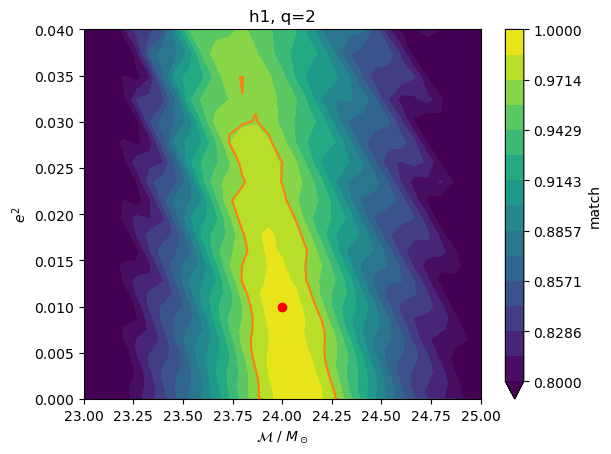

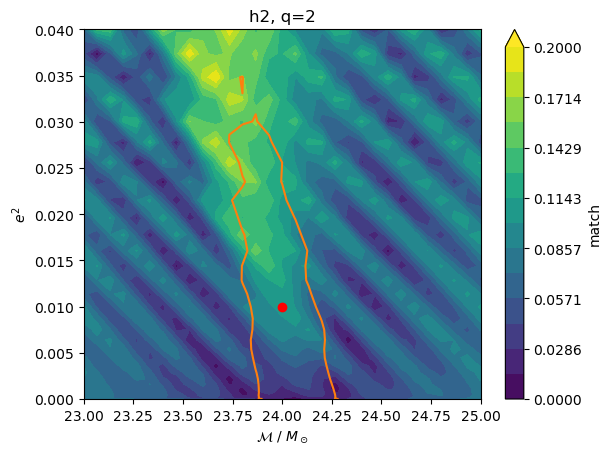

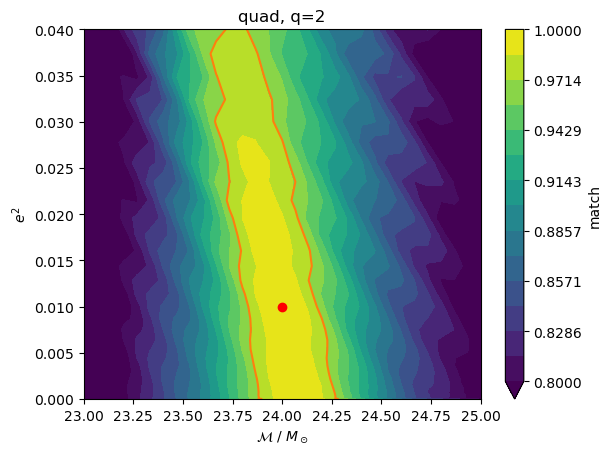

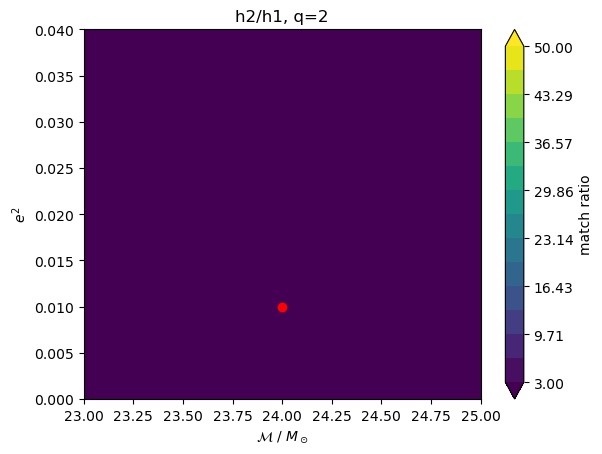

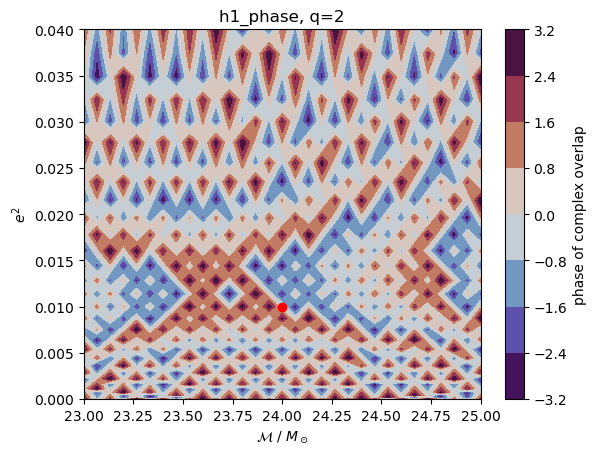

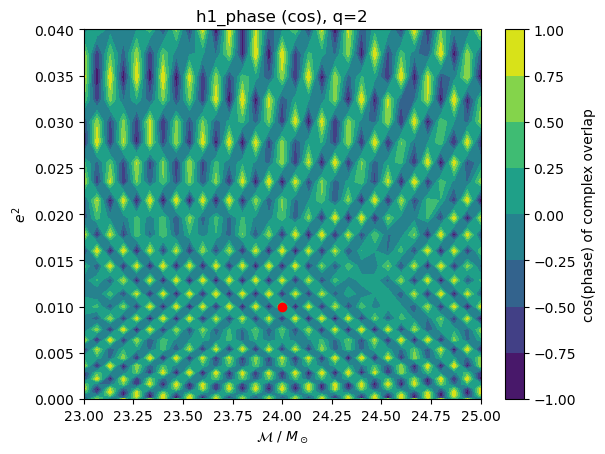

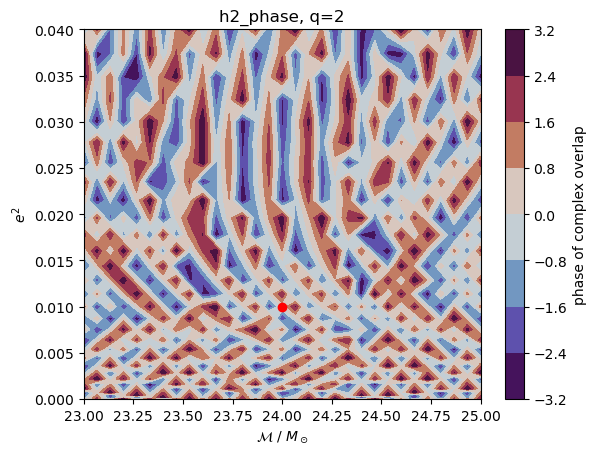

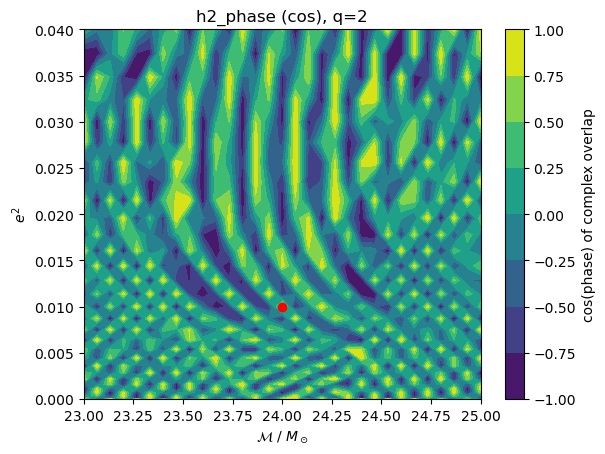

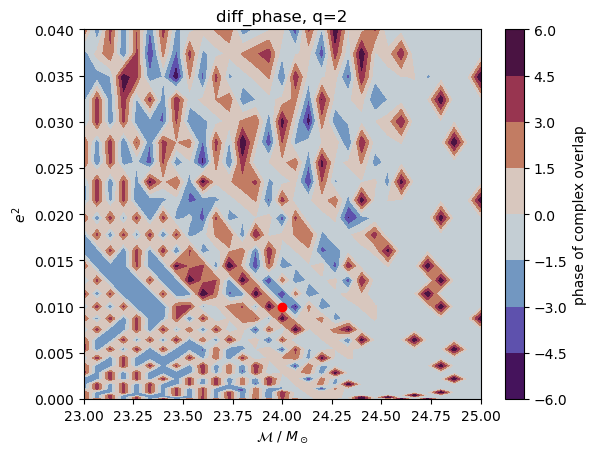

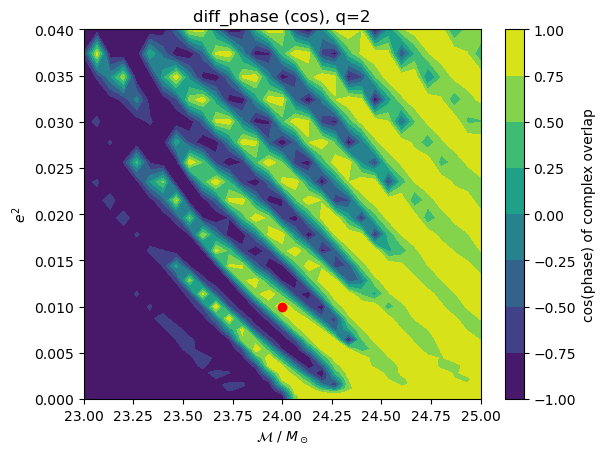

In [76]:
ecc_chirp_plot(e_vals_0, chirp_vals_0, [0.1, 24, 2], dataslot_0, vmins=[0.8,0,0.8,3], vmaxs=[1,0.2,1,50])

## Maximisation over shifted frequencies with the phase difference method (2 TEOB calls per grid point)

In [77]:
e_vals_1 = np.linspace(0, 0.2, 31)
chirp_vals_1 = np.linspace(23, 25, 31)
start = time.time()
dataslot_1 = ecc_chirp_match(e_vals_1, chirp_vals_1, [0.1, 24, 2], 10, max_method='phase_diff')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

961 done out of 961
Time taken: 2770.6615149974823 seconds


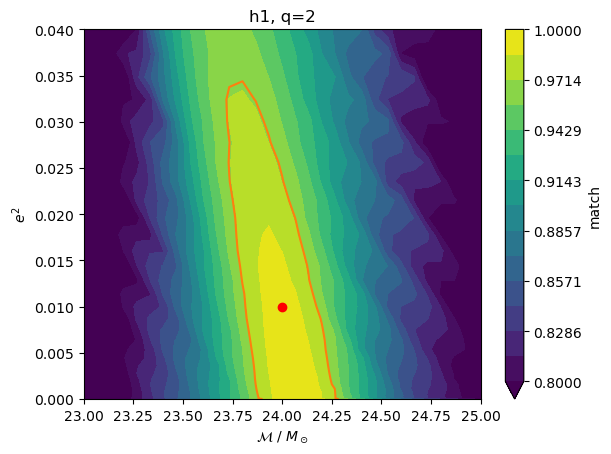

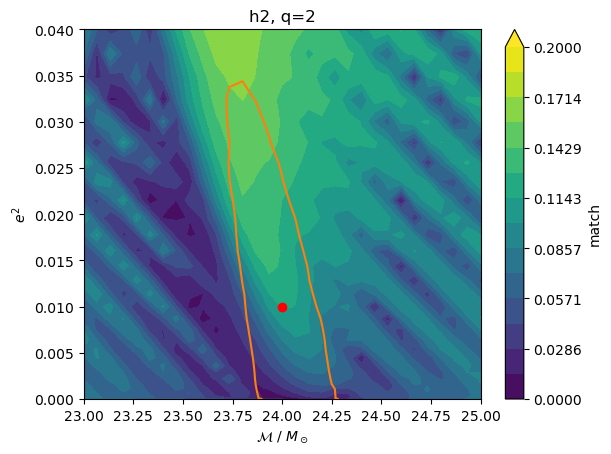

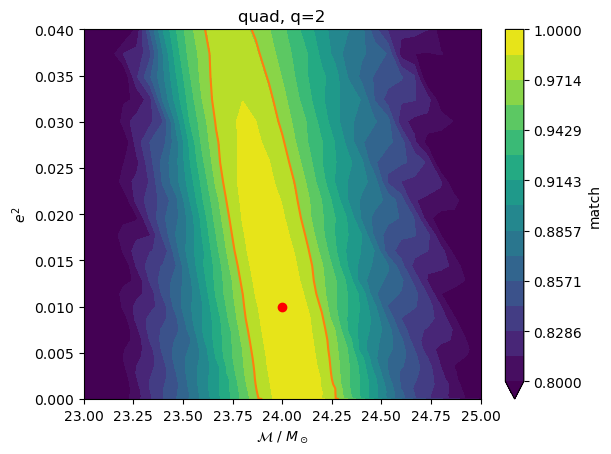

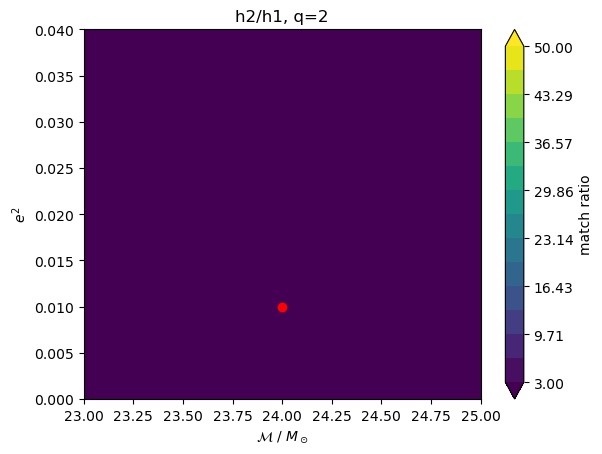

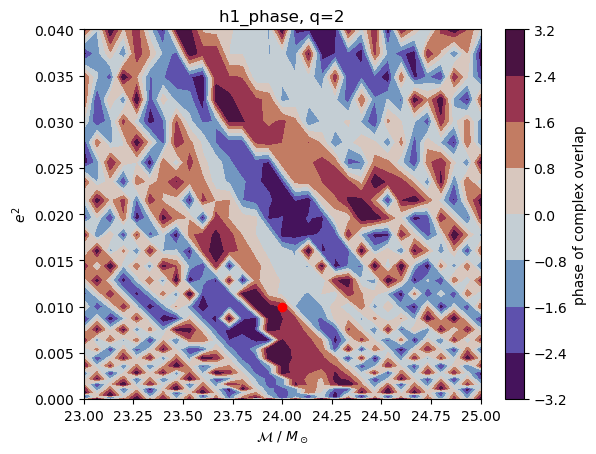

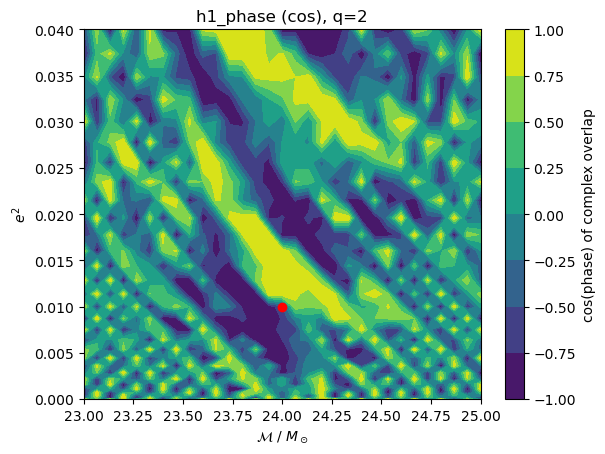

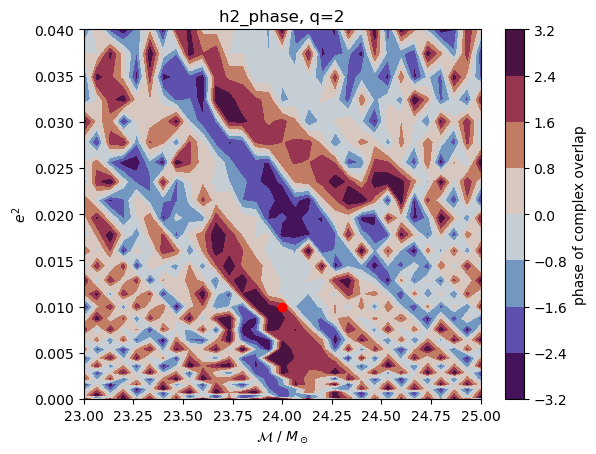

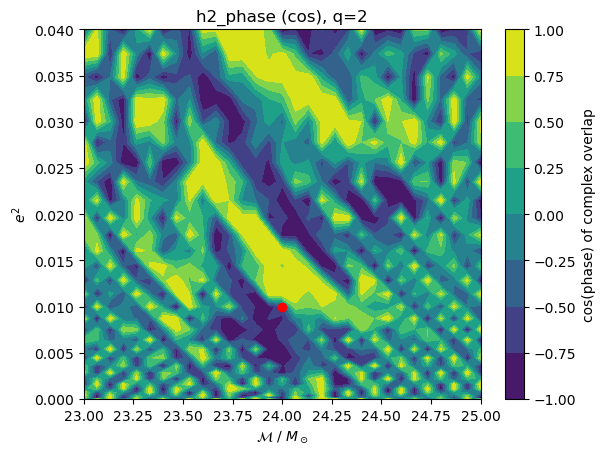

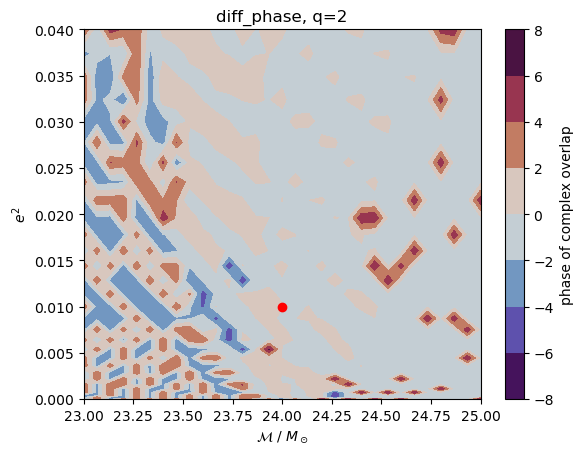

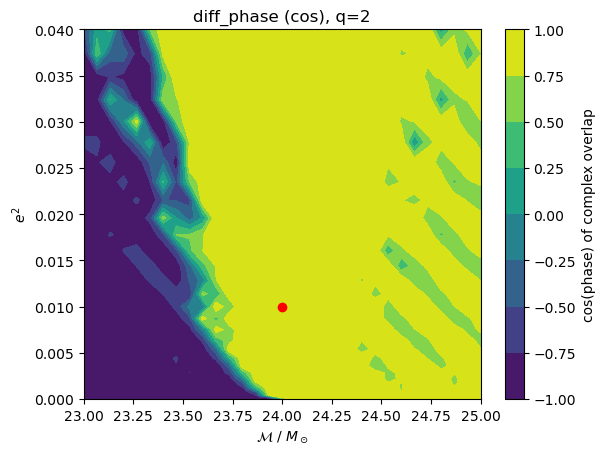

In [78]:
ecc_chirp_plot(e_vals_1, chirp_vals_1, [0.1, 24, 2], dataslot_1, vmins=[0.8,0,0.8,3], vmaxs=[1,0.2,1,50])

## Maximisation over shifted frequencies with the sine approximation method (4 TEOB calls per grid point)

In [79]:
e_vals_2 = np.linspace(0, 0.2, 31)
chirp_vals_2 = np.linspace(23, 25, 31)
start = time.time()
dataslot_2 = ecc_chirp_match(e_vals_2, chirp_vals_2, [0.1, 24, 2], 10, max_method='sine_approx')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

961 done out of 961
Time taken: 5548.240231752396 seconds


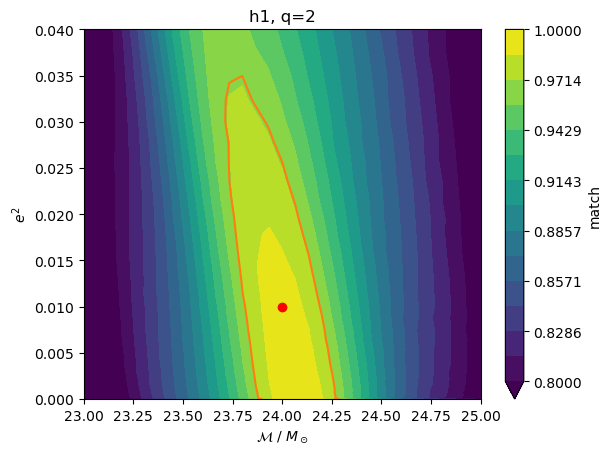

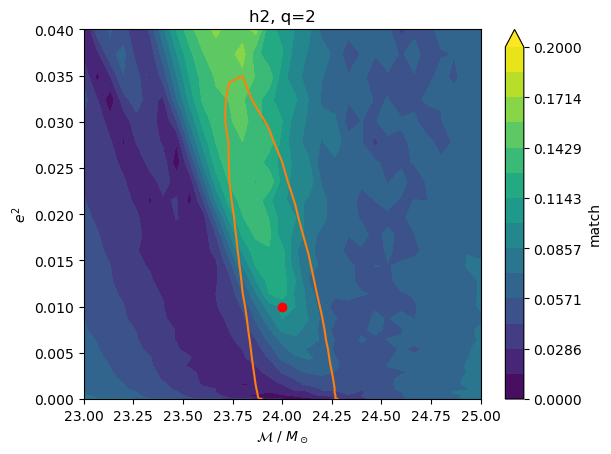

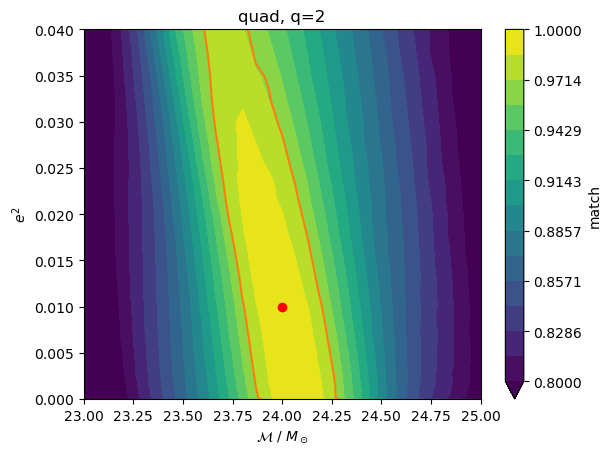

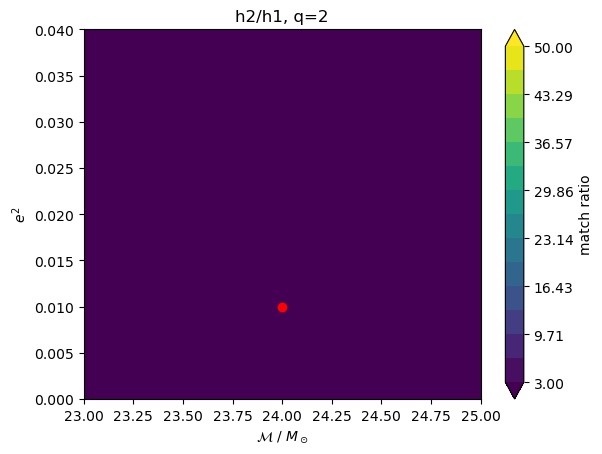

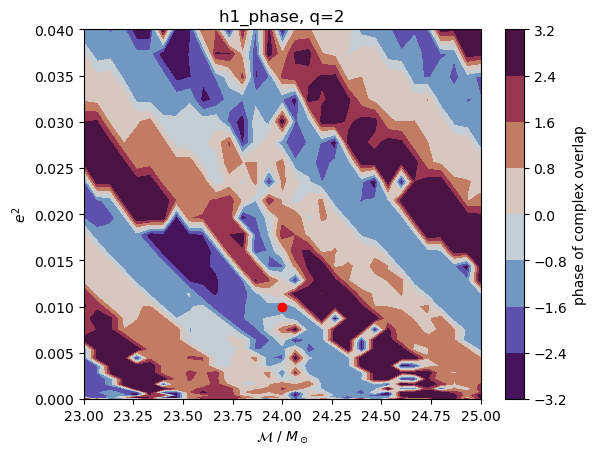

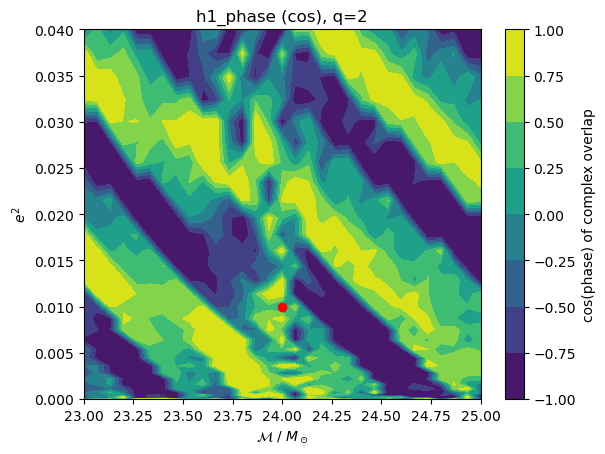

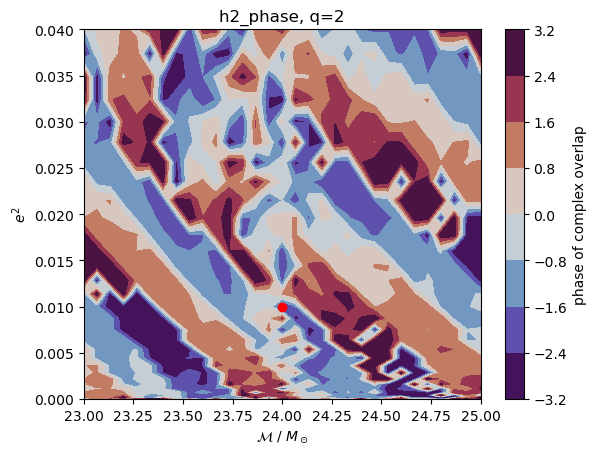

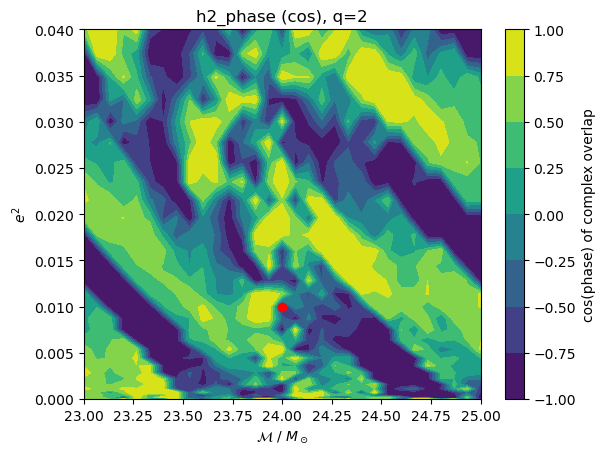

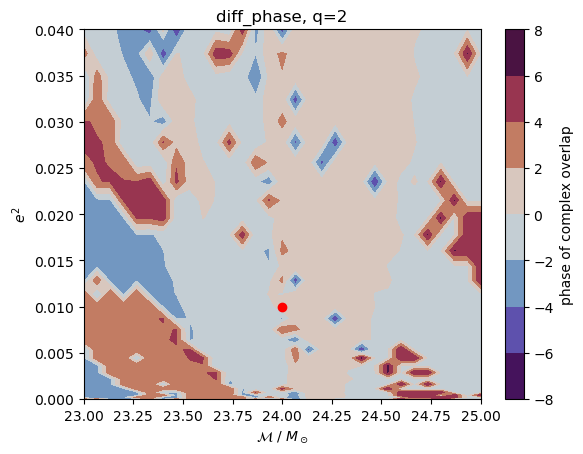

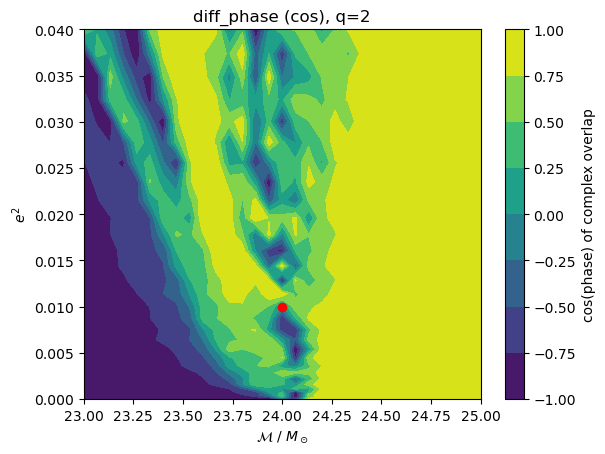

In [80]:
ecc_chirp_plot(e_vals_2, chirp_vals_2, [0.1, 24, 2], dataslot_2, vmins=[0.8,0,0.8,3], vmaxs=[1,0.2,1,50])

## Phase diff method, shifting h1/h2, final match TEOB (4 TEOB calls per gridpoint)

In [81]:
e_vals_3 = np.linspace(0, 0.2, 31)
chirp_vals_3 = np.linspace(23, 25, 31)
start = time.time()
dataslot_3 = ecc_chirp_match_ta(e_vals_3, chirp_vals_3, [0.1, 24, 2], 10, final_match='TEOB')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

961 done out of 961
Time taken: 6759.073053598404 seconds


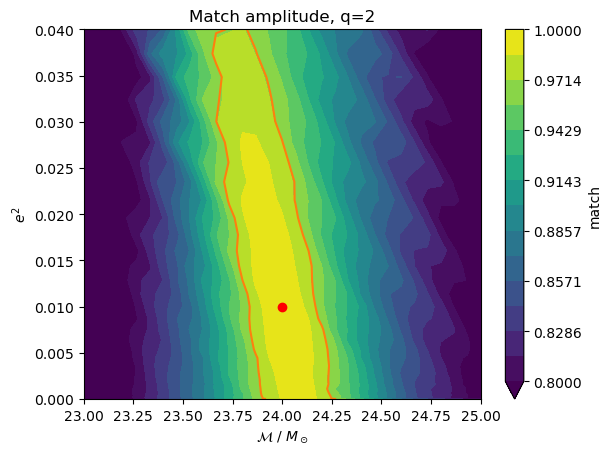

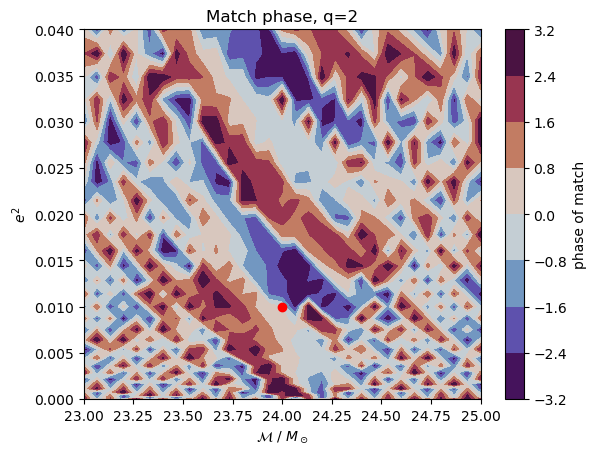

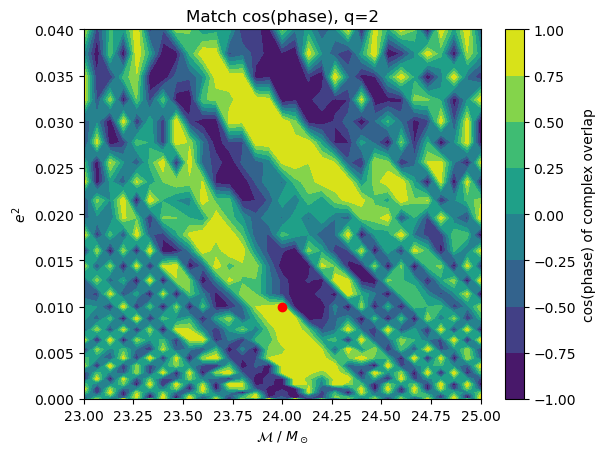

In [82]:
ecc_chirp_plot_ta(e_vals_3, chirp_vals_3, [0.1, 24, 2], dataslot_3, vmin=0.8, vmax=1)

## Phase diff method, shifting h1/h2, final match quad (6 TEOB calls per gridpoint)

In [ ]:
e_vals_4 = np.linspace(0, 0.2, 31)
chirp_vals_4 = np.linspace(23, 25, 31)
start = time.time()
dataslot_4 = ecc_chirp_match_ta(e_vals_4, chirp_vals_4, [0.1, 24, 2], 10, final_match='quad')
end = time.time()
print(f'\nTime taken: {end-start} seconds')

729 done out of 961

In [ ]:
ecc_chirp_plot(e_vals_4, chirp_vals_4, [0.1, 24, 2], dataslot_4, vmins=[0.8,0,0.8,0], vmaxs=[1,0.4,1,0.2])

## Using 2 SVD waveforms generated with 100 training waveforms

In [ ]:
e_vals_5 = np.linspace(0, 0.2, 31)
chirp_vals_5 = np.linspace(23, 25, 31)
start = time.time()
dataslot_5 = ecc_chirp_match_svd(e_vals_5, chirp_vals_5, 'U_matrix_2svd_100t.pkl', [0.1, 24, 2], 10)
end = time.time()
print(f'\nTime taken: {end-start} seconds')

In [ ]:
ecc_chirp_plot(e_vals_5, chirp_vals_5, [0.1, 24, 2], dataslot_5, vmins=[0.8,0,0.8,0], vmaxs=[1,0.4,1.001,0.5])